The goal of the project is to check if Ukrainian politicians plagiarize each others manifesto. It consists of 3 parts:
1. Web-scraping of all manifestors of candidates that was running for parlamentarian elections. 
2. Processing and extracting of text from files with manifestos.
3. Analysis of the similarity of texts using the method of N-grams. 

#### Step 3. Analysis of the similarity of texts using the method of N-grams. 

In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
programs = pd.read_csv('/home/olena/Desktop/parse_cvk_2019/programs/programs.csv', low_memory = False) 
cands = pd.read_csv('/home/olena/Desktop/parse_cvk_2019/programs/cands_info.csv', low_memory = False) 

In [8]:
# cleaning and preparing for merge
programs['name'] = programs['name'].str.replace(r'changed_', '')
programs['name'] = programs['name'].str.replace(r'–', '-')
programs['txt'] = programs['txt'].str.replace('\n','', regex=True)
programs = programs.drop('Unnamed: 0', axis=1)

In [10]:
cands['Прізвище, ім`я та по батькові кандидата в депутати'] = cands['Прізвище, ім`я та по батькові кандидата в депутати'].replace(' ', '', regex=True)
cands.rename(columns={'Прізвище, ім`я та по батькові кандидата в депутати':'ПІБ'}, inplace=True)

cands = cands.drop('Unnamed: 0', axis=1)

In [14]:
cands.head()

,ПІБ,Передвиборна програма,Основні відомості,Округ,Наявність(відсутність) заборгованості зі сплати аліментів,Дата та підстава скасування реєстрації кандидата,Дата реєстрації кандидатом,Висування,Область
0,БевзСвітланаВолодимирівна,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народилася 4 листопада 1973 року в місті Вінни...,Одномандатний виборчий округ №11,-,,20.06.2019,Самовисування,Вінницька область
1,ГижкоАндрійПетрович,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,"народився 27 червня 1978 року в місті Вінниці,...",Одномандатний виборчий округ №11,-,,24.06.2019,"Політична партія ""Європейська Солідарність""",Вінницька область
2,ГорлачовІгорЯрославович,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народився 31 березня 1984 року в місті Вінниці...,Одномандатний виборчий округ №11,-,,24.06.2019,"Політична партія ""ОПОЗИЦІЙНА ПЛАТФОРМА – ЗА ЖИ...",Вінницька область
3,ДавиденкоГаннаВіталіївна,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народилася 24 травня 1983 року в місті Вінниці...,Одномандатний виборчий округ №11,-,,24.06.2019,Самовисування,Вінницька область
4,КістіонВолодимирЄвсевійович,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,народився 31 травня 1965 року в селі Довжок Ям...,Одномандатний виборчий округ №11,-,,12.06.2019,Самовисування,Вінницька область


In [16]:
programs.head()

,name,txt,url
0,АбдуллаєвІджранЯгубогли,Передвиборча програма кандидата на у на...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
1,АбрамовОлегГеннадійович,Передвиборна прогр...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
2,АбрамчукДмитроВалентинович,ПЕРЕДВИБОРНА ПРОГРАМА КАНДИДАТА В ДЕПУТАТИ ...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
3,АвраменкоОлексійСергійович,Передвиборча прогр...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...
4,АврамчукДмитроВасильович,ПЕРЕДВИБОРНА ПРОГР...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...


In [17]:
programs_merged = pd.merge(programs, cands, how = 'left', left_on = ['name', 'url'], right_on = ['ПІБ', 'Передвиборна програма'])

In [18]:
programs_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3205 entries, 0 to 3204
Data columns (total 12 columns):
name                                                         3205 non-null object
txt                                                          3205 non-null object
url                                                          3205 non-null object
ПІБ                                                          3191 non-null object
Передвиборна програма                                        3191 non-null object
Основні відомості                                            3191 non-null object
Округ                                                        3191 non-null object
Наявність(відсутність) заборгованості зі сплати аліментів    3191 non-null object
Дата та підстава скасування реєстрації кандидата             3191 non-null object
Дата реєстрації кандидатом                                   3191 non-null object
Висування                                                    3191 non-nul

In [26]:
# Preparing dataset with manifestos from 2019 for comparison
# Candidates that are running from certain parties use standard manifesto, so we drop don't need them all.

# In this step we exclude standard programs from dataframe

programs_comparison = programs.loc[(programs['Висування'] != 'Політична партія "ОПОЗИЦІЙНА ПЛАТФОРМА – ЗА ЖИТТЯ"') &
                                                                                           (programs['Висування'] != 'політична партія Всеукраїнське об’єднання "Свобода"') &
                                                                                           (programs['Висування'] != 'Політична партія "ОПОЗИЦІЙНИЙ БЛОК"') &
                                                                                           (programs['Висування'] != 'Політична Партія "ПАТРІОТ"') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "СИЛА І ЧЕСТЬ') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "УКРАЇНА СЛАВЕТНА"') &
                                                                                           (programs['Висування'] != 'СОЦІАЛІСТИЧНА ПАРТІЯ УКРАЇНИ') &
                                                                                           (programs['Висування'] != 'Аграрна партія України') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "ДЕМОКРАТИЧНА СОКИРА"') &
                                                                                           (programs['Висування'] != 'ПРАВИЙ СЕКТОР') &
                                                                                           (programs['Висування'] != 'ПОЛІТИЧНА ПАРТІЯ "СВІДОМА НАЦІЯ"') &
                                                                                           (programs['Висування'] != 'Політична партія "Народний Рух України"') &
                                                                                           (programs['Висування'] != 'Політична партія "Партія місцевого самоврядування"')]

programs_comparison.shape

(2671, 12)

In [27]:
# In this step we create a new dataframe with one example of each party's standard program

programs_one = programs.loc[(programs['Висування'] == 'Політична партія "ОПОЗИЦІЙНА ПЛАТФОРМА – ЗА ЖИТТЯ"') |
                                                                                           (programs['Висування'] == 'політична партія Всеукраїнське об’єднання "Свобода"') |
                                                                                           (programs['Висування'] == 'Політична партія "ОПОЗИЦІЙНИЙ БЛОК"') |
                                                                                           (programs['Висування'] == 'Політична Партія "ПАТРІОТ"') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "СИЛА І ЧЕСТЬ') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "УКРАЇНА СЛАВЕТНА"') |
                                                                                           (programs['Висування'] == 'СОЦІАЛІСТИЧНА ПАРТІЯ УКРАЇНИ') |
                                                                                           (programs['Висування'] == 'Аграрна партія України') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "ДЕМОКРАТИЧНА СОКИРА"') |
                                                                                           (programs['Висування'] == 'ПРАВИЙ СЕКТОР') |
                                                                                           (programs['Висування'] == 'ПОЛІТИЧНА ПАРТІЯ "СВІДОМА НАЦІЯ"') |
                                                                                           (programs['Висування'] == 'Політична партія "Народний Рух України"') |
                                                                                           (programs['Висування'] == 'Політична партія "Партія місцевого самоврядування"')]
print(programs_one.shape)
programs_one = programs_one.groupby('Висування').first().reset_index()

programs_one = programs_one[['name', 'txt', 'url', 'ПІБ', 'Передвиборна програма',
       'Основні відомості', 'Округ', 'Наявність(відсутність) заборгованості зі сплати аліментів',
       'Дата та підстава скасування реєстрації кандидата', 'Дата реєстрації кандидатом', 'Висування', 'Область']]

(534, 12)


In [28]:
# then we combine them together again

programs = pd.concat([programs_comparison, programs_one], ignore_index = True)

In [29]:
programs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2682 entries, 0 to 2681
Data columns (total 12 columns):
name                                                         2682 non-null object
txt                                                          2682 non-null object
url                                                          2682 non-null object
ПІБ                                                          2682 non-null object
Передвиборна програма                                        2682 non-null object
Основні відомості                                            2682 non-null object
Округ                                                        2682 non-null object
Наявність(відсутність) заборгованості зі сплати аліментів    2682 non-null object
Дата та підстава скасування реєстрації кандидата             2682 non-null object
Дата реєстрації кандидатом                                   2682 non-null object
Висування                                                    2682 non-nul

In [86]:
# pip install strsim

  Using cached https://files.pythonhosted.org/packages/0d/95/14e5dea00c3bc73e5962261442957ee3691de8d51c97909ba7b2f46bf584/strsim-0.0.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# calculate n-grams distance

from similarity.qgram import QGram
from datetime import datetime
import itertools

dist_list = []
df = []

qgram = QGram(6)

j = 0
l = [(row.url, row.txt) for index, row in programs.iterrows()]

for p1, p2 in itertools.combinations(l, 2):
    
    j += 1
    
    dist_dict = {}
    
    dist_dict['dist'] = qgram.distance(str(p1[1]).lower(),str(p2[1]).lower())
    dist_dict['index_p1'] = p1[0]
    dist_dict['index_p2'] = p2[0]
    dist_dict['p1_d'] = p1[1]
    dist_dict['p2_d'] = p2[1]
    
    dist_list.append(dist_dict)
    
    if j % 1000 == 0:
        print(j, datetime.now())

df = pd.DataFrame(dist_list)

In [128]:
df.shape

(3595221, 5)

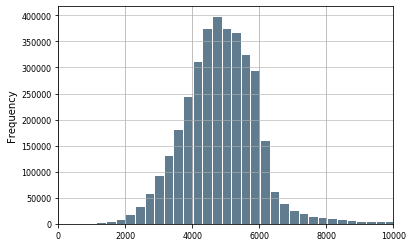

In [132]:
df['dist'].plot.hist(grid=True, bins=200, rwidth=0.9,
                   color='#607c8e', xlim=(0,10000))
params = {'axes.titlesize':'4',
          'xtick.labelsize':'4',
          'ytick.labelsize':'4'}
matplotlib.rcParams.update(params)
plt.grid(axis='y', alpha=0.75)

In [133]:
# top 10 most similar manifestos
df.sort_values(by = 'dist').head(10)

,dist,index_p1,index_p2,p1_d,p2_d
860382,0.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Політична програма кандидата в наро...,Політична програма кандидата в наро...
178801,37.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,ПЕРЕДВИБОРЧА ПРОГР...,ПЕРЕДВИБОРЧА ПРОГР...
1921767,52.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна прогр...,Передвиборна прогр...
3581366,53.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Пункти передвиборч...,Пункти передвиборч...
3208073,55.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборча програма кандидата у нар...,Передвиборча програма кандидата у нар...
975879,61.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Гаврилюк Василь Васильович кандидат в нар...,Рибак Ю.О. кандидат в народні депутати України...
2774542,63.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна програма кандидата у нар...,Передвиборна програма кандидата у нар...
3595017,65.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,2\t\t2ПЕРЕДВИБОРНА ПРОГРАМАкандидата у народні...,2\t\t2ПЕРЕДВИБОРНА ПРОГРАМАкандидата у народні...
920372,66.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна програма кандидата у...,Передвиборна програма кандидата у...
2519614,66.0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,Передвиборна прогр...,Передвиборна прогр...


In [186]:
# for each program choosing corresponding pair with lowest distance
manifestos_grams_dist = df.sort_values('dist').drop_duplicates(['index_p1'])

In [187]:
# storing in local dir
manifestos_grams_dist[['dist', 'index_p1', 'index_p2']].to_csv('/home/olena/CHESNO/manifestos_grams_dist.csv')

In [29]:
# manifestos_grams_dist = pd.read_csv('/home/olena/CHESNO/manifestos_grams_dist', low_memory = False)

In [73]:
# fun for similarity ratio calculation

from diff_match_patch import diff_match_patch

def compute_similarity_and_diff(text1, text2):
    dmp = diff_match_patch()
    dmp.Diff_Timeout = 0.0
    diff = dmp.diff_main(text1, text2, False)

    # similarity
    common_text = sum([len(txt) for op, txt in diff if op == 0])
    text_length = max(len(text1), len(text2))
    sim = common_text / text_length

    return sim

In [75]:
# calculating similarity ratio for pairs with lowest n-grams dist
from datetime import datetime

sim_list = []
i = 0

for index_p1, index_p2, p1_d, p2_d in zip(manifestos_grams_dist['index_p1'], 
                                          manifestos_grams_dist['index_p2'], 
                                          manifestos_grams_dist['p1_d'], 
                                          manifestos_grams_dist['p2_d']):
        
    i += 1
        
    sim_dict = {}
    sim_dict['index_p1'] = index_p1
    sim_dict['index_p2'] = index_p2
    sim_dict['sim_ratio'] = compute_similarity_and_diff(str(p1_d).lower(),str(p2_d).lower()) # or maybe better to try Jaccard

    sim_list.append(sim_dict)

    if i % 100 == 0:
        print(i, datetime.now())

100 2019-07-10 12:58:20.847001
200 2019-07-10 12:58:51.228311
300 2019-07-10 12:59:32.025592
400 2019-07-10 13:00:18.824071
500 2019-07-10 13:01:17.051244
600 2019-07-10 13:02:41.206859
700 2019-07-10 13:04:00.362993
800 2019-07-10 13:05:29.547378
900 2019-07-10 13:07:01.742968
1000 2019-07-10 13:09:08.047992
1100 2019-07-10 13:10:45.944789
1200 2019-07-10 13:13:05.411537
1300 2019-07-10 13:15:49.297253
1400 2019-07-10 13:18:23.610671
1500 2019-07-10 13:20:45.285073
1600 2019-07-10 13:24:00.840296
1700 2019-07-10 13:26:47.500873
1800 2019-07-10 13:30:25.083052
1900 2019-07-10 13:32:29.005577
2000 2019-07-10 13:35:20.684923
2100 2019-07-10 13:37:58.904870
2200 2019-07-10 13:40:33.378549
2300 2019-07-10 13:43:03.214835
2400 2019-07-10 13:45:46.609570
2500 2019-07-10 13:49:11.284880
2600 2019-07-10 13:52:24.194193


In [79]:
similar_programs = pd.DataFrame(sim_list)

In [80]:
similar_programs.shape

(2681, 3)

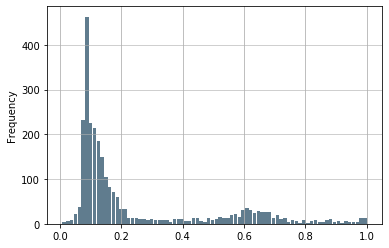

In [33]:
# distribution of similarity ratios

similar_programs['sim_ratio'].plot.hist(grid=True, bins=80, rwidth=0.9, color='#607c8e')
params = {'axes.titlesize':'12',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12'}
matplotlib.rcParams.update(params)
plt.grid(axis='y', alpha=0.75)

In [133]:
similar_programs.to_csv('/home/olena/CHESNO/similar_programs.csv')

In [30]:
# similar_programs = pd.read_csv('/home/olena/CHESNO/similar_programs.csv')
# similar_programs = similar_programs.drop('Unnamed: 0', axis=1)

In [31]:
# selecting only programs with level of similarity > 50%
similar_programs_top = similar_programs.loc[similar_programs['sim_ratio'] > 0.5]
print(similar_programs_top.shape)
similar_programs_top.head()

(528, 3)


,index_p1,index_p2,sim_ratio
0,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,1.000000
1,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.997111
2,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.997370
3,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.829907
4,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,https://www.cvk.gov.ua/pls/vnd2019/showdocpf72...,0.993860


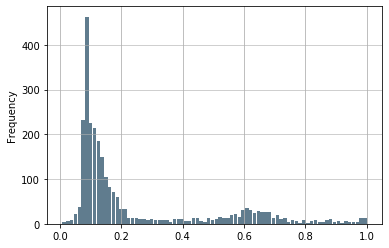

In [31]:
similar_programs['sim_ratio'].plot.hist(grid=True, bins=80, rwidth=0.9, color='#607c8e')
plt.grid(axis='y', alpha=0.75)

In [32]:
# adding info about candidates to manifestos (using link as unique to program on website of Electoral Comission)

merged_1 = pd.merge(similar_programs, programs[['name', 'url', 'Округ', 'Висування', 
                                                     'Дата реєстрації кандидатом']], how = 'left',
                    left_on = 'index_p1', right_on = 'url')
merged_1.columns = ['index_p1', 'index_p2', 'sim_ratio', 'name_p1', 'url_p1', 'Округ_p1', 'Висування_p1', 'p1_date']
merged = pd.merge(merged_1, programs[['name', 'url', 'Округ', 'Висування', 'Дата реєстрації кандидатом']], 
                  how = 'left', left_on = 'index_p2', right_on = 'url')
merged.columns = ['index_p1', 'index_p2', 'sim_ratio', 'name_p1', 'url_p1', 'Округ_p1', 'Висування_p1', 'p1_date',
                    'name_p2', 'url_p2', 'Округ_p2', 'Висування_p2', 'p2_date']
merged = merged[['index_p1', 'index_p2', 'sim_ratio', 'name_p1', 'Округ_p1', 'Висування_p1', 'p1_date', 'name_p2', 
                 'Округ_p2', 'Висування_p2', 'p2_date']]


In [ ]:
plagiarism_dif_parties = merged.loc[(merged['Висування_p1'] == 'Самовисування') |
                                    (merged['Висування_p2'] == 'Самовисування') |
                                    (merged['Висування_p1'] != merged['Висування_p2'])]
plagiarism_diff = plagiarism_dif_parties.loc[plagiarism_dif_parties['sim_ratio'] > 0.5].sort_values(by = 'sim_ratio', ascending = False)
plagiarism_diff

In [34]:
plagiarism_diff.to_csv('/home/olena/CHESNO/manifestos_plagiarism.csv')